In [5]:
from obspy import read
import pandas as pd
import glob
import os
from datetime import datetime, timedelta

path_to_merge = "../Fechas/"
# Find all data.csv files in the segments folders
csv_files = glob.glob(os.path.join(path_to_merge, "**/segments/data.csv"), recursive=True)

all_events = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    
    # Filter only rows with p_wave_frame (not deleted and has p-wave picks)
    df = df[df['p_wave_frame'].notna() & ~df['deleted']]
    
    for _, row in df.iterrows():
        # Extract timestamp from trace_path
        trace_name = row['trace_path']
        start_time_str = trace_name.split('_')[1]
        
        # Convert to datetime
        start_time = datetime.strptime(start_time_str, '%Y%m%dT%H%M%S')
        start_time_unix = start_time.timestamp()
        
        # Get p_wave_frame values (could be multiple)
        p_frames = eval(row['p_wave_frame'])
        if not isinstance(p_frames, list):
            p_frames = [p_frames]
            
        # For each p-wave pick in the frame
        for p_frame in p_frames:
            # Calculate p_wave_time (each frame is 0.01s)
            p_wave_time = start_time + timedelta(seconds=p_frame * 0.01)
            end_time = p_wave_time + timedelta(seconds=10)
            
            station = read(os.path.join(path_to_merge, start_time.strftime('%Y-%m-%d'), "segments", trace_name + '.mseed'))[0].stats.station
            all_events.append({
                'station': station,
                'file': f"{start_time.strftime('%Y-%m-%d')}/{station}_{start_time.strftime('%Y-%m-%d')}_Z.mseed",
                'p_wave_in_utc_time': p_wave_time.strftime('%Y-%m-%d %H:%M:%S'),
            })

# Create final dataframe
result_df = pd.DataFrame(all_events)
result_df.index.name = 'event_id'

# Save to CSV
result_df.to_csv('merged_events.csv')

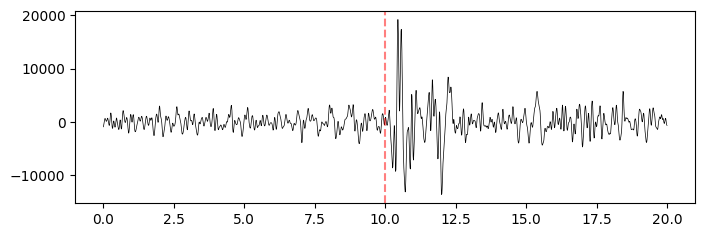

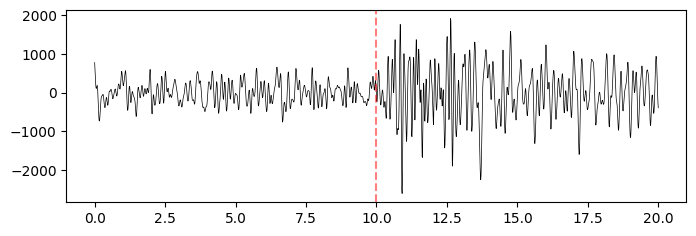

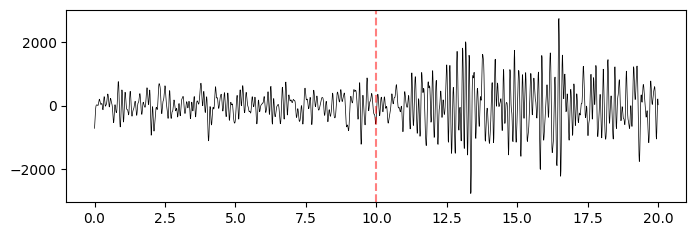

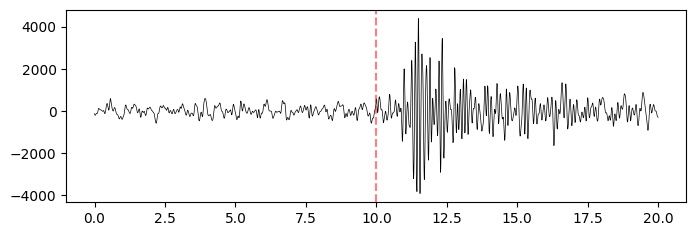

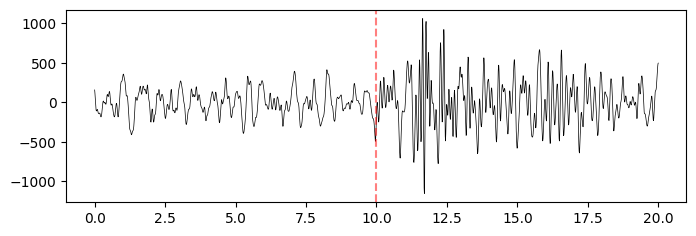

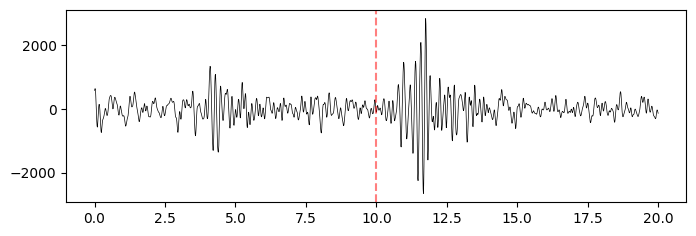

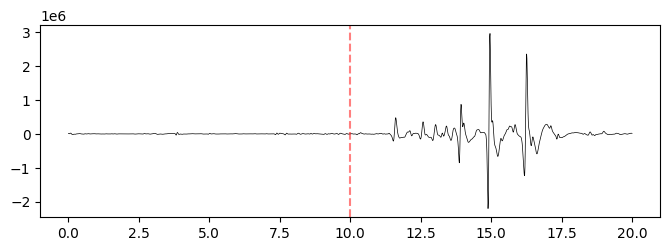

In [13]:
from obspy import read
import matplotlib.pyplot as plt
from obspy import UTCDateTime

df = pd.read_csv('s03_etiquetado.csv')
# carpeta donde estan los MSEED
path_to_merge = "./S03/"
for _, row in df.iterrows():
    st = read(os.path.join(path_to_merge, row['file']))
    st.filter("bandpass", freqmin=1, freqmax=10)
    st_s = st.slice(starttime=UTCDateTime(pd.to_datetime(row['p_wave_in_utc_time'])-timedelta(seconds=10)), endtime=UTCDateTime(pd.to_datetime(row['p_wave_in_utc_time']) + timedelta(seconds=10)))
    
    fig, ax = plt.subplots(figsize=(8, 2.5))
    ax.plot(st_s[0].times(), st_s[0].data, 'k', linewidth=0.5)
    ax.axvline(x=10, color='r', linestyle='--', alpha=0.5)
    plt.show()
   

